In [1]:
import pandas as pd
import numpy as np
import gc
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import MinMaxScaler


from myutils import reduce_mem_usage

lentrain = 1503424
lentest = 508438
lentrainactive = 14129821
lentestactive = 12824068

categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
dropcols = ['Weekday']

In [2]:
def scale_standard(df, ignorecol=[]):
    cols = deepcopy(df.columns)
    for col in cols:
        #print(col)
        if (str(df[col].dtype)[:5] == 'float') and (not col in ignorecol):
            temp = SS().fit_transform(df[col].values.ravel().reshape(-1, 1))
            df[col] = temp.flatten()
    return df

def get_smalldiff(df1, df2, userate=0.2):
    assert (df1.columns == df2.columns).all(), 'inputs must have same columns'
    th = np.uint(df1.shape[1] * userate)
    criteria = {'mean': np.mean, 'var': np.var, 'median': np.median}
    difflist = []
    tempdiff = pd.DataFrame()
    tempdiff['colname'] = [col for col in df1.columns]
    for k, c in criteria.items():
        tempdiff[k] = [np.abs(c(df1[col]) - c(df2[col])) for col in df1.columns]
    tempdiff = scale_standard(tempdiff, ignorecol=['colname'])
    sums = np.zeros(tempdiff.shape[0])
    for key in criteria.keys():
        sums += np.abs(tempdiff[key])
    tempdiff['result'] = sums
    sortdiff = tempdiff.sort_values(by='result')
    print(sortdiff[['colname', 'result']])
    return sortdiff['colname'][: th].tolist()

def loadfeather(trpath, tepath, reader=pd.read_feather):
    train = reader(trpath)
    test = reader(tepath)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)    
    df = pd.concat([train, test])
    del train, test; gc.collect()
    print(df.nunique())
    return df

def plothist(df):
    sidesplit = 3
    versplit = len(df.columns)//sidesplit + 1
    width = 4*sidesplit
    height = 3*versplit
    plt.figure(figsize=(width, height))
    for i, col in enumerate(df.columns):
        plt.subplot(versplit, sidesplit, i+1)
        plt.hist(df.iloc[:, i], label=col) 
        plt.legend()
    plt.show()

def plotcorr(df):
    colsize = len(df.columns)
    width = 6 + np.uint(colsize*0.2)
    height = 4 + np.uint(colsize*0.2)
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.set(style='white')
    f, ax = plt.subplots(figsize=(width, height))
    cmap = sns.diverging_palette(30, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
def concat2master(df, dfmaster):
    print(df.shape)
    #print(df.isnull().sum())
    df = reduce_mem_usage(df)
    #print(df.columns)
    #print(df.dtypes)
    for col in df.columns:
        dfmaster[col] = df[col]
    del df; gc.collect()
    print(dfmaster.shape)
    print(dfmaster.memory_usage().sum() / 1024**2, ' MB')
    return dfmaster

def scale_minmax(df, ignorecol=[]):
    cols = deepcopy(df.columns)
    for col in cols:
        if (str(df[col].dtype)[:3] == 'int') or (str(df[col].dtype)[:4] == 'uint'):
            print(col)
            temp = MinMaxScaler().fit_transform(df[col].values.ravel().reshape(-1, 1))
            df[col] = temp.flatten()
    return df

def choose_unique(df):
    print(f'before: {len(df.columns)}')
    uniques = {col: df[col].nunique() for col in df.columns}
    uniques_list = []
    for val in set(uniques.values()):
        temp = [k for k, v in uniques.items() if v == val]
        uniques_list.append(temp)
    uniques_list
    choiced = [str(np.random.choice(l, 1)[0]) for l in uniques_list]
    print(f'after: {len(choiced)}')
    return choiced

In [3]:
dfmaster = pd.DataFrame()

user_id                         1009909
region                               28
city                               1752
parent_category_name                  9
category_name                        47
param_1                             372
param_2                             278
param_3                            1277
price                             20761
item_seq_number                   33947
user_type                             3
image_top_1                        3064
Weekday                               7
desc_punc                           739
description_num_words               558
description_num_unique_words        353
description_words_vs_unique       12341
title_num_words                      17
title_num_unique_words               15
title_words_vs_unique                36
ridge_preds                     1954410
dtype: int64
user_id 1009909
region 28
city 1752
parent_category_name 9
category_name 47
user_type 3
image_top_1 3064
param_1 372
param_2 278
param_3 1277


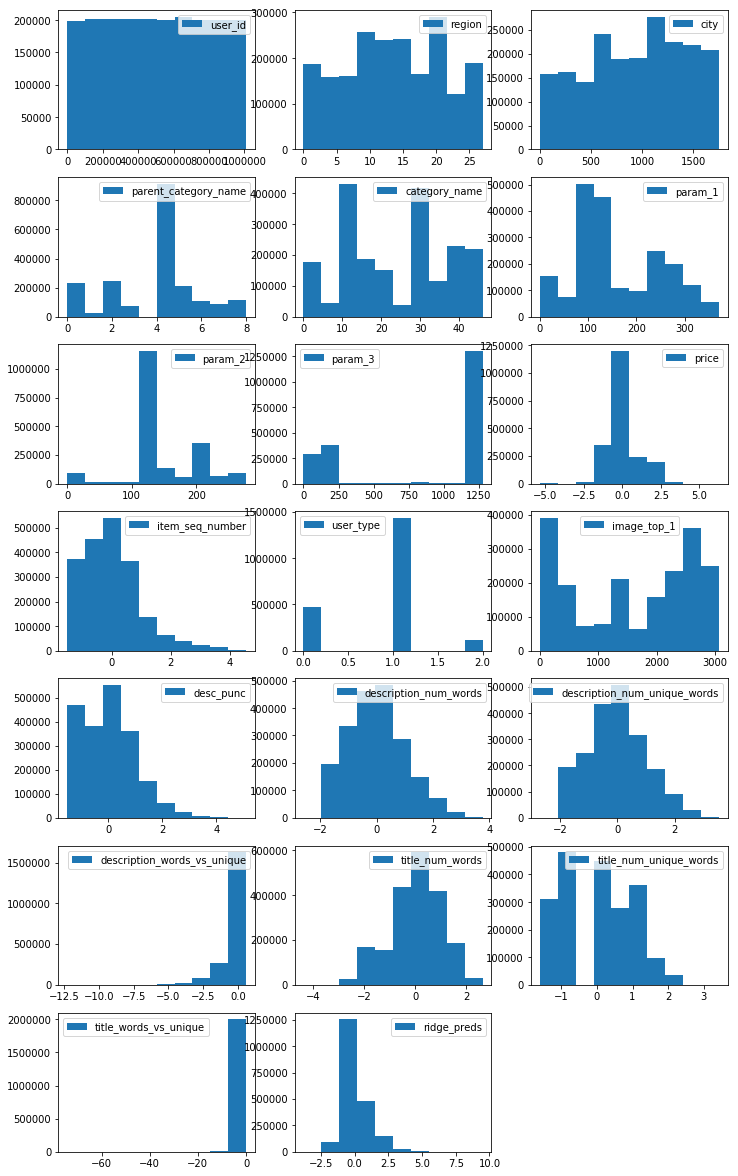

(2011862, 20)
Memory usage of dataframe is 322.34 MB
Memory usage after optimization is: 126.63 MB
Decreased by 60.7%
(2011862, 20)
126.63163375854492  MB


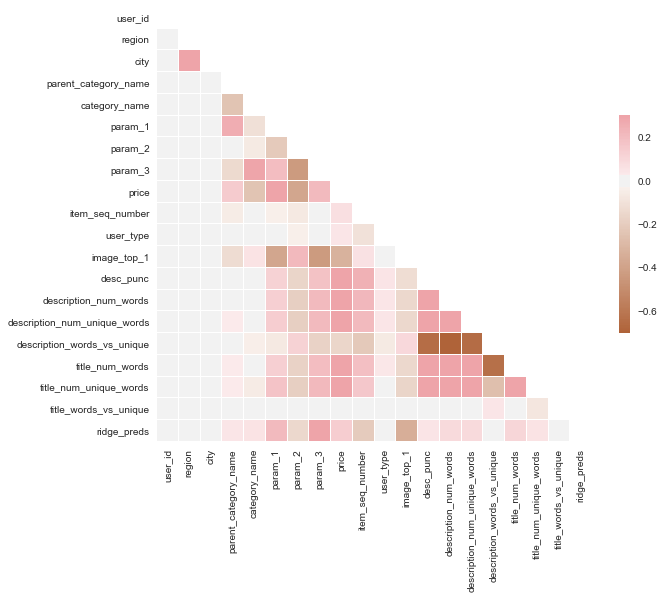

In [4]:
df = loadfeather('./kernel_train.feather', './kernel_test.feather')
for col in categorical:
    print(col, str(df[col].nunique()))
df['desc_punc'] = np.log1p(df['desc_punc'])
df['description_num_words'] = np.log1p(df['description_num_words'])
df['description_num_unique_words'] = np.log1p(df['description_num_unique_words'])
df['title_num_words'] = np.log1p(df['description_num_words'])
df['title_num_unique_words'] = np.log1p(df['title_num_unique_words'])
df['description_words_vs_unique'].fillna(df['description_words_vs_unique'].mean(), inplace=True)
df['item_seq_number'] = np.log1p(df['item_seq_number'])

df.drop(dropcols, axis=1, inplace=True)
df = scale_standard(df, ignorecol=categorical)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

avg_days_up_user         17413
avg_times_up_user         7204
avg_headdays_up_user     29551
n_user_items               956
avg_price_up_user       161337
var_price_up_user       309985
dtype: int64


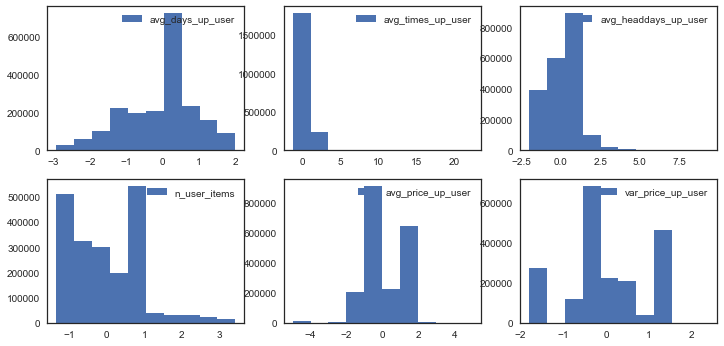

                colname    result
4     avg_price_up_user  2.157388
3          n_user_items  2.369647
1     avg_times_up_user  2.633943
0      avg_days_up_user  2.708459
5     var_price_up_user  2.797616
2  avg_headdays_up_user  4.140698
(2011862, 6)
Memory usage of dataframe is 61.40 MB
Memory usage after optimization is: 61.40 MB
Decreased by 0.0%
(2011862, 26)
172.67950057983398  MB


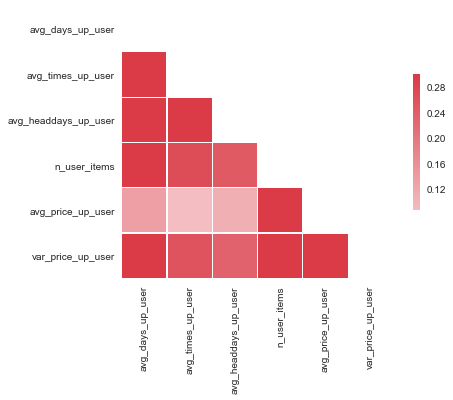

In [5]:
# User Data Agg
df = loadfeather('../features/train/Agg_User_train.feather', '../features/test/Agg_User_test.feather')
df['n_user_items'] = np.log1p(df['n_user_items'])
df['avg_price_up_user'] = np.log(df['avg_price_up_user']+0.001)
df['var_price_up_user'] = np.log(df['var_price_up_user']+0.001)
df = scale_standard(df)
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)


title_titleword_count                   15
title_upper_case_word_count             15
title_num_stopwords                     10
title_num_punctuations                  19
title_num_alphabets                      1
title_num_digits                         1
title_num_chars                         51
title_num_words                         17
title_num_unique_words                  15
title_chars_by_words                   285
title_words_by_uniquewords              42
title_punctuations_by_chars            260
title_punctuations_by_words            109
title_digits_by_chars                    1
title_alphabets_by_chars                 1
title_stopwords_by_words                49
title_mean                             282
description_titleword_count            226
description_upper_case_word_count      212
description_num_stopwords              151
description_num_punctuations           739
description_num_alphabets                2
description_num_digits                   1
description

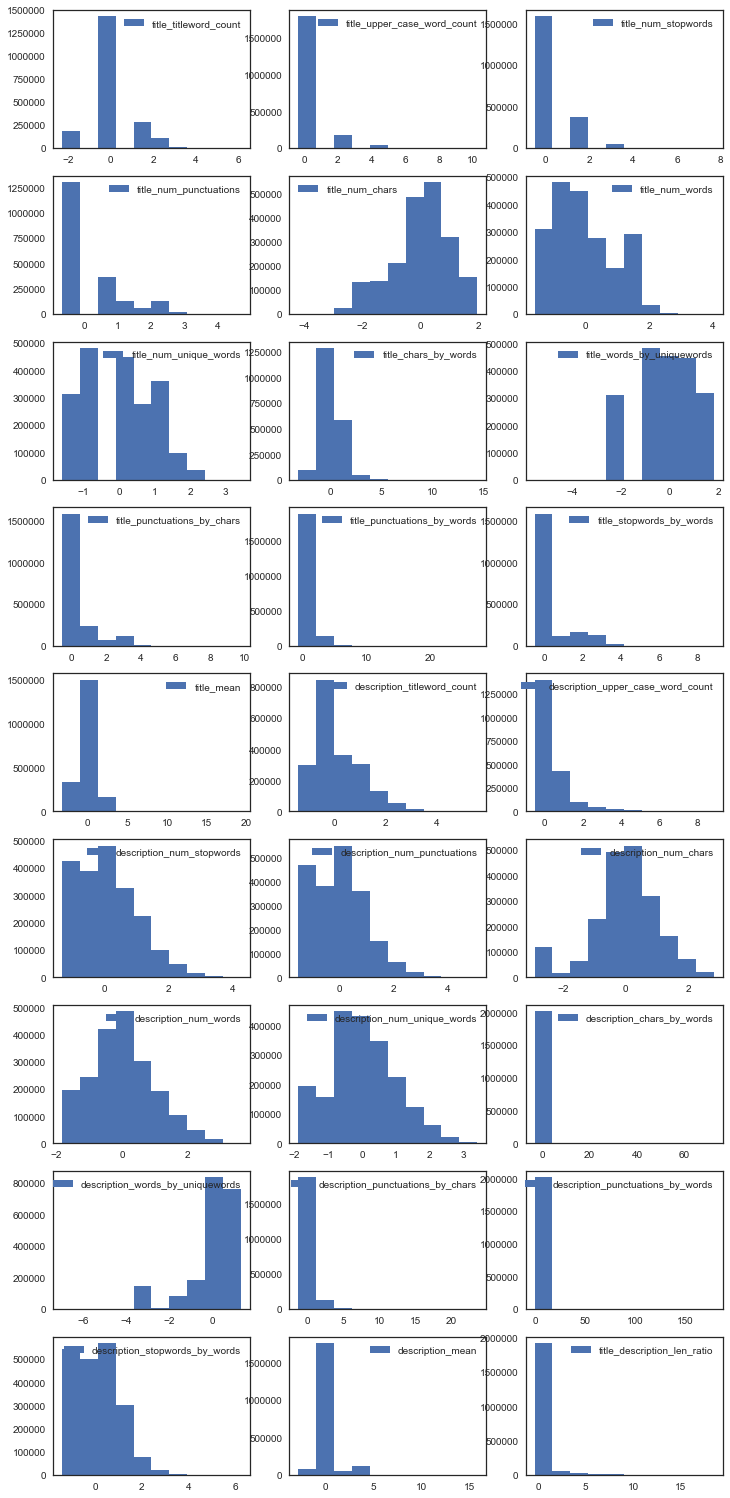

                              colname    result
22  description_punctuations_by_chars  1.185927
15          description_num_stopwords  1.251768
14  description_upper_case_word_count  1.328459
13        description_titleword_count  1.336173
23  description_punctuations_by_words  1.407820
19       description_num_unique_words  1.740240
1         title_upper_case_word_count  1.768018
8          title_words_by_uniquewords  1.957222
5                     title_num_words  1.987111
6              title_num_unique_words  1.987129
0               title_titleword_count  1.991918
4                     title_num_chars  2.006135
9         title_punctuations_by_chars  2.009514
3              title_num_punctuations  2.081599
12                         title_mean  2.106978
11           title_stopwords_by_words  2.115404
7                title_chars_by_words  2.167480
2                 title_num_stopwords  2.175166
10        title_punctuations_by_words  2.207745
17              description_num_chars  2

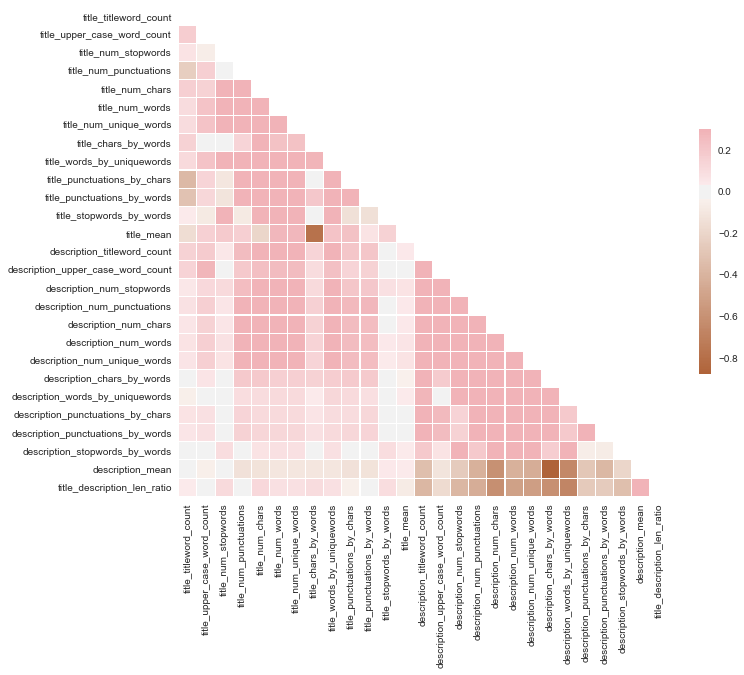

In [6]:
# Text features
df = loadfeather('../features/train/textfeatures_train.feather', '../features/test/textfeatures_test.feather')
for col in df.columns:
    col_spl = col.split('_')
    #print(col, df[col].min(), df[col].max())
    if col_spl[-1] == 'count' or col_spl[-2] == 'num' or col.count('num_unique_words'):
        df[col] = np.log1p(df[col])
        df[col] = df[col].astype('float32')

# 意味のないcolは落とす
droplist = ['title_num_alphabets', 'title_num_digits', 'description_num_digits', 'description_num_alphabets',
            'title_digits_by_chars', 'title_alphabets_by_chars', 'description_digits_by_chars', 'description_alphabets_by_chars']
df = df.drop(droplist, axis=1)
df = scale_standard(df)

plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)

city-parent_category_name-param_123_numunique                     780
region-city-category_name-param_1_numunique                       148
category_name-user_type-param_1-param_123_numunique                64
region-param_123_numunique                                         54
region-city-parent_category_name-param_123_numunique              780
category_name-user_type-param_1-city_numunique                   1099
region-city-user_type_numunique                                     8
region-parent_category_name-param_123-category_name_numunique      16
region-city-parent_category_name_numunique                         17
region-parent_category_name-param_123_numunique                   160
city-param_123-category_name_numunique                             92
city-param_1-param_123-category_name_numunique                     92
region-city-param_1-param_123_numunique                           588
region-city-param_123-user_type_numunique                           8
region-user_type-cit

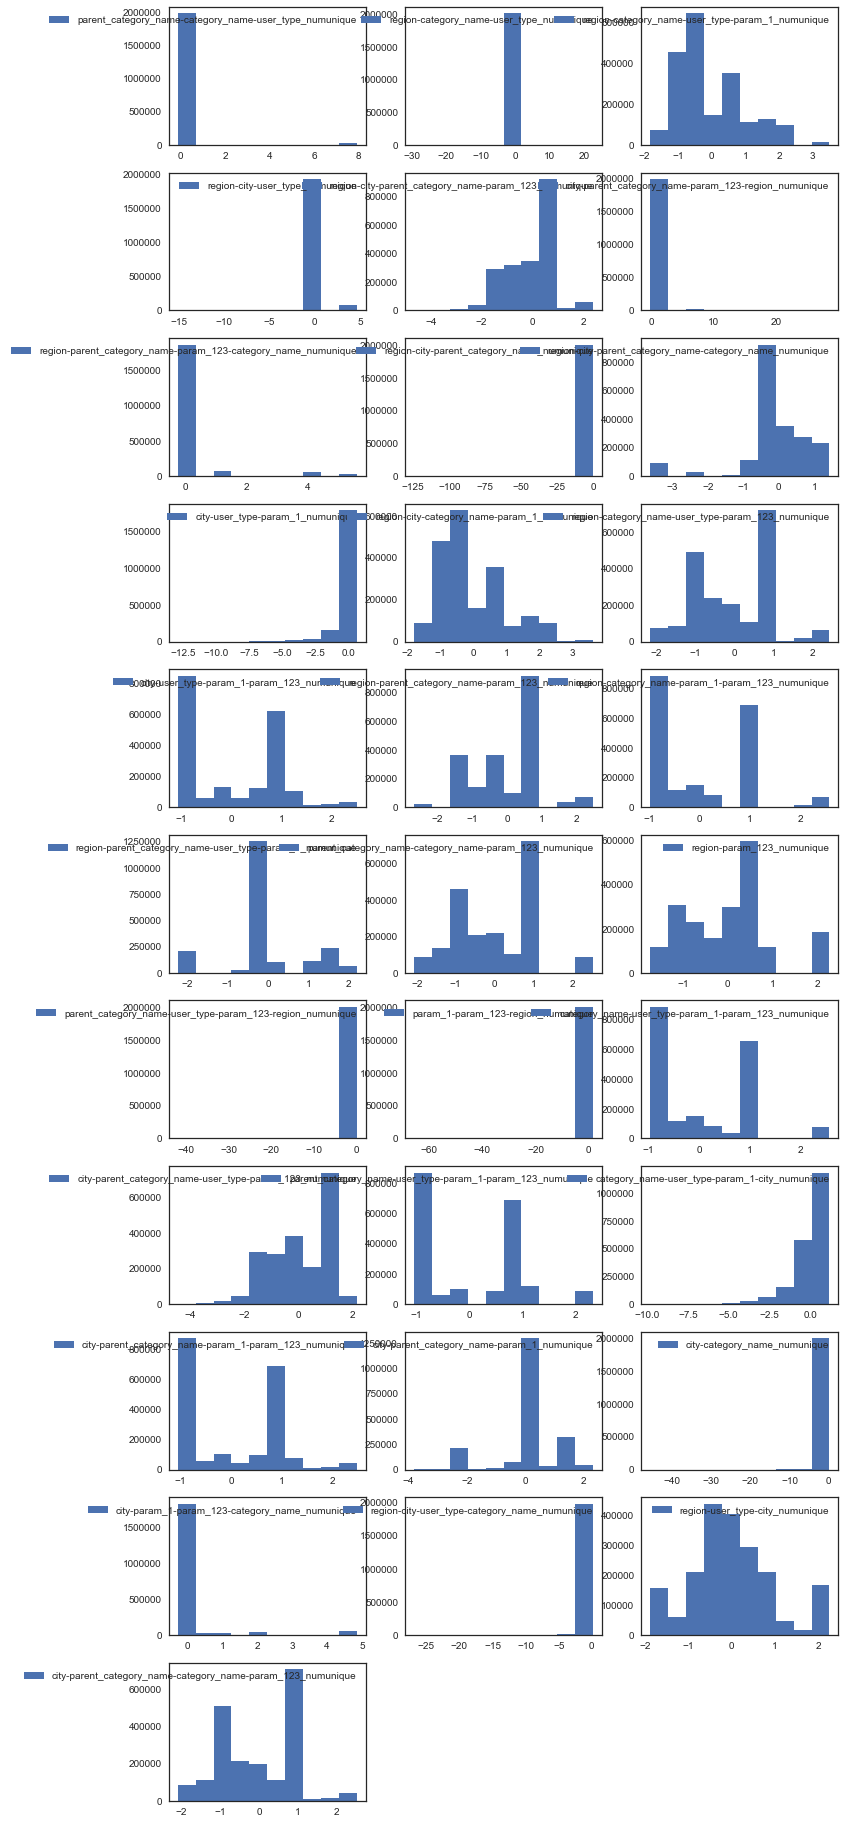

                                              colname    result
20  category_name-user_type-param_1-param_123_numu...  1.045382
23     category_name-user_type-param_1-city_numunique  1.097477
24  city-parent_category_name-param_1-param_123_nu...  1.129726
12         city-user_type-param_1-param_123_numunique  1.210703
25        city-parent_category_name-param_1_numunique  1.311141
28      region-city-user_type-category_name_numunique  1.316597
9                    city-user_type-param_1_numunique  1.333055
30  city-parent_category_name-category_name-param_...  1.450183
17                         region-param_123_numunique  1.597630
18  parent_category_name-user_type-param_123-regio...  1.686053
6   region-parent_category_name-param_123-category...  1.704726
15  region-parent_category_name-user_type-param_1_...  1.759125
5   city-parent_category_name-param_123-region_num...  1.900979
14   region-category_name-param_1-param_123_numunique  1.940412
16  parent_category_name-category_name-p

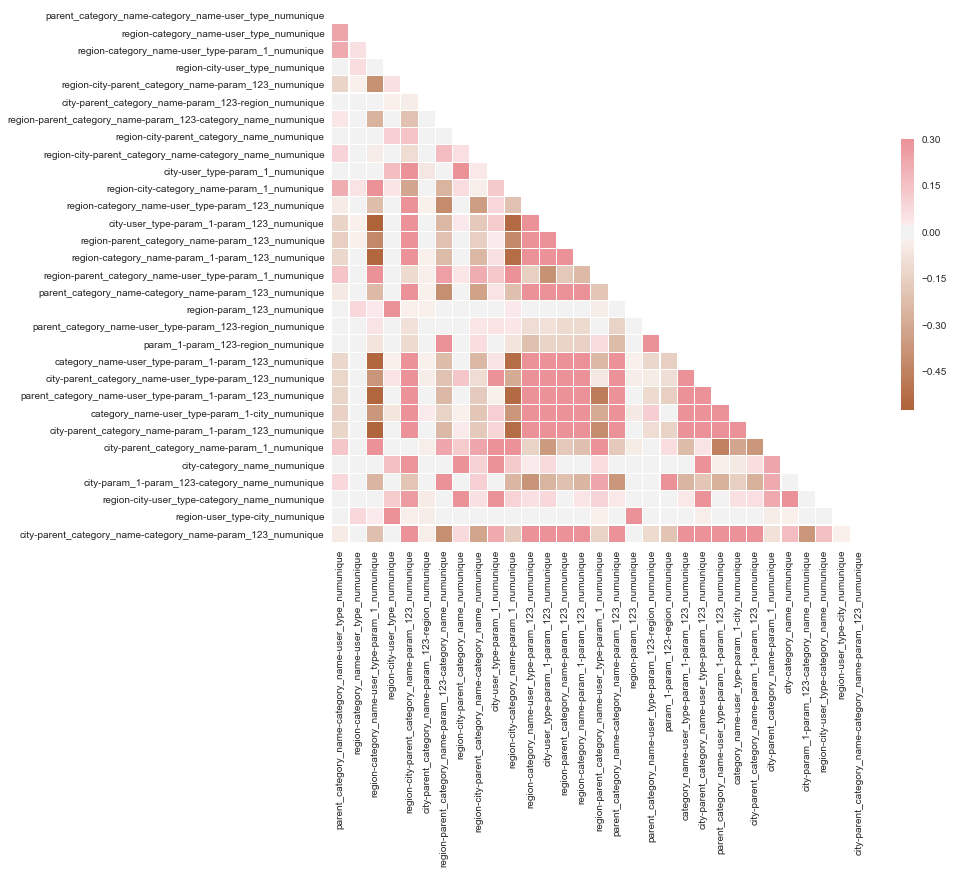

In [7]:
# Unique
df = loadfeather('../features/train/Agg_Unique_Silver_train.feather', '../features/test/Agg_Unique_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)

region-user_type_numcount                                           168
param_1-param_123_numcount                                         2656
param_123_numcount                                                 2656
parent_category_name-user_type-weekofday-param_1_numcount          3944
region-city-weekofday_numcount                                     3472
city-parent_category_name_numcount                                 4592
city-weekofday_numcount                                            3475
region-parent_category_name-user_type-param_1_numcount             7398
region-user_type-param_1_numcount                                  7077
parent_category_name-category_name-param_1-param_123_numcount      2760
parent_category_name-category_name-param_123_numcount              2760
category_name-param_1-param_123_numcount                           2760
category_name-param_123_numcount                                   2760
region-user_type-weekofday_numcount                             

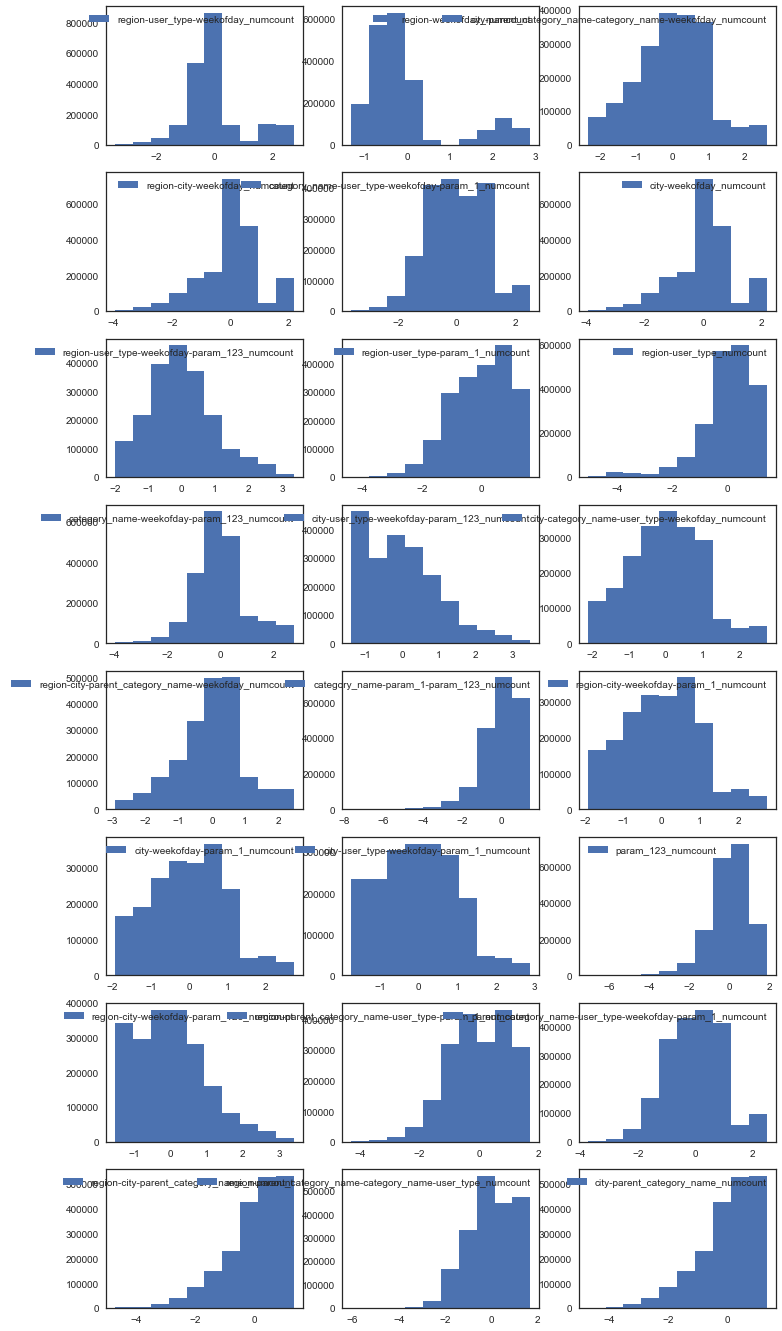

                                              colname    result
17                                 param_123_numcount  0.627427
5                             city-weekofday_numcount  0.698775
0                 region-user_type-weekofday_numcount  1.191282
20  parent_category_name-user_type-weekofday-param...  1.391917
2   city-parent_category_name-category_name-weekof...  1.565391
15                    city-weekofday-param_1_numcount  1.596486
11    city-category_name-user_type-weekofday_numcount  1.602233
19  region-parent_category_name-user_type-param_1_...  1.774842
8                           region-user_type_numcount  1.985658
14             region-city-weekofday-param_1_numcount  2.031120
3                      region-city-weekofday_numcount  2.174191
9          category_name-weekofday-param_123_numcount  2.185551
16          city-user_type-weekofday-param_1_numcount  2.275061
13           category_name-param_1-param_123_numcount  2.299352
22  region-parent_category_name-category

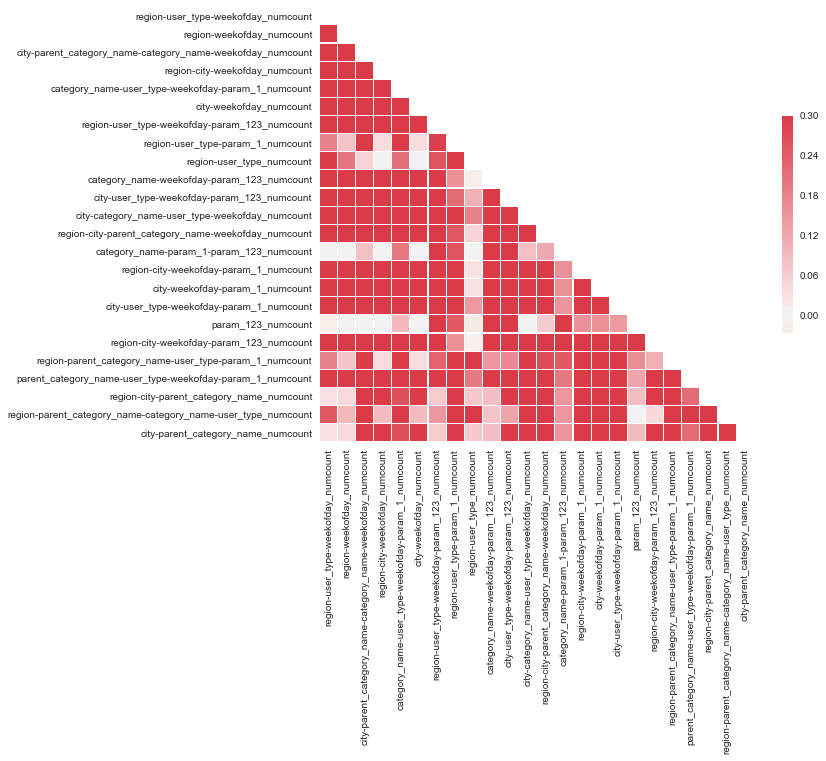

In [8]:
# Count Agg

df = loadfeather('../features/train/Agg_Count_Silver_train.feather', '../features/test/Agg_Count_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)


imagefeatures__dullness                 20000
imagefeatures__whiteness                19999
imagefeatures__average_pixel_width     385129
imagefeatures__image_size               91662
imagefeatures__blurrness              1800693
imagefeatures__average_red            1728771
imagefeatures__average_green          1707081
imagefeatures__average_blue           1702035
imagefeatures__width                      609
imagefeatures__height                     452
dtype: int64
imagefeatures__image_size
imagefeatures__width
imagefeatures__height


C:\Users\ahega\Anaconda3\envs\Avito18_Kaggle\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ahega\Anaconda3\envs\Avito18_Kaggle\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


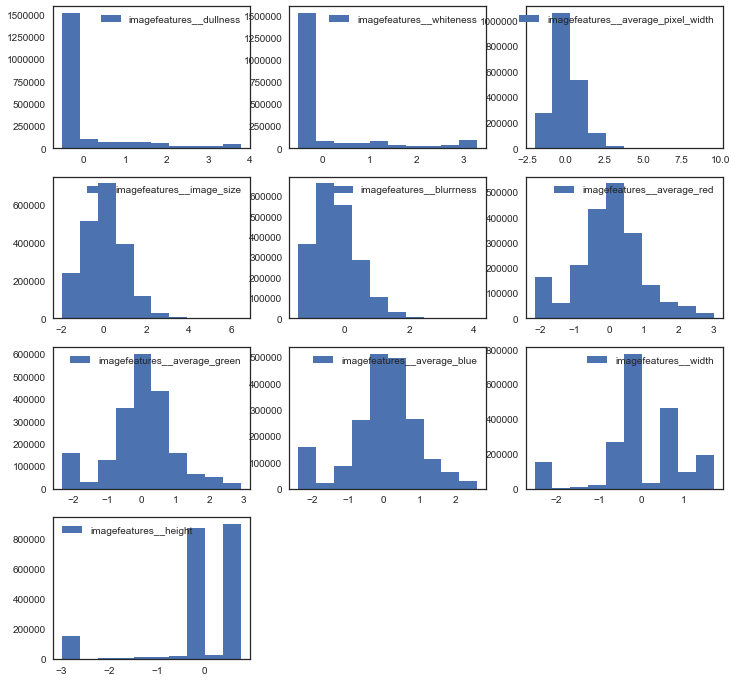

(2011862, 10)
Memory usage of dataframe is 115.12 MB
Memory usage after optimization is: 92.10 MB
Decreased by 20.0%
(2011862, 114)
848.0482139587402  MB


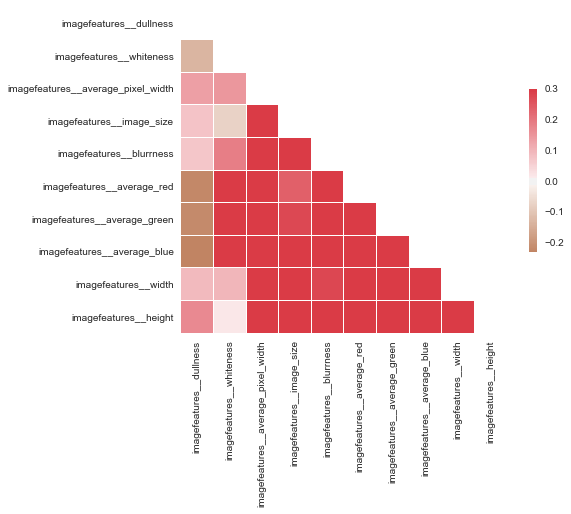

In [9]:
# Image Features
df = loadfeather('../features/train/imagefeatures_train.feather', '../features/test/imagefeatures_test.feather')
df = scale_minmax(df)
df = scale_standard(df)
df['imagefeatures__blurrness'] = np.log1p(df['imagefeatures__blurrness'])
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

imagenet_Resnet50_top1    1737109
imagenet_Resnet50_top2    1790338
imagenet_Resnet50_top3    1793828
dtype: int64


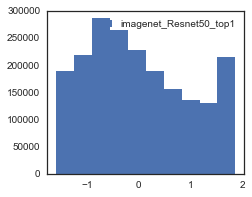

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 115)
855.7228584289551  MB
imagenet_IndeptionV3_top1     579634
imagenet_IndeptionV3_top2    1725460
imagenet_IndeptionV3_top3    1728988
dtype: int64


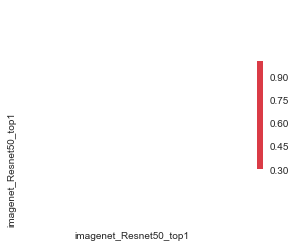

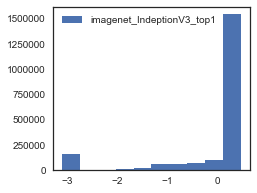

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 116)
863.3975028991699  MB
imagenet_Xception_top1    1085618
imagenet_Xception_top2    1823811
imagenet_Xception_top3    1828911
dtype: int64


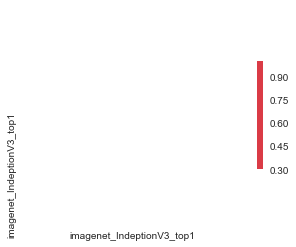

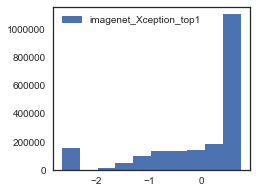

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 117)
871.0721473693848  MB
imagenet_Movilenet_top1    1767470
imagenet_Movilenet_top2    1765864
imagenet_Movilenet_top3    1757845
dtype: int64


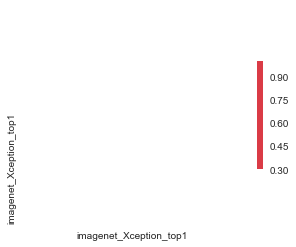

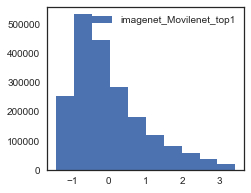

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 118)
878.7467918395996  MB


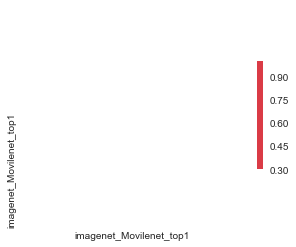

In [10]:
# imagenet
# Resnet50
df = loadfeather('../features/train/imagenet_Resnet50_train.feather', '../features/test/imagenet_Resnet50_test_debug.feather')
usecol = ['imagenet_Resnet50_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

# Inception V3
df = loadfeather('../features/train/imagenet_IndeptionV3_train.feather', '../features/test/imagenet_IndeptionV3_test_debug.feather')
usecol = ['imagenet_IndeptionV3_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

# Xception
df = loadfeather('../features/train/imagenet_Xception_train.feather', '../features/test/imagenet_Xception_test_debug.feather')
usecol = ['imagenet_Xception_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

# Mobilenet
df = loadfeather('../features/train/imagenet_Movilenet_train_debug.feather', '../features/test/imagenet_Movilenet_test_debug.feather')
usecol = ['imagenet_Movilenet_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

img_mean_color     1833427
img_std_color      1845394
img_blue_mean      1816516
img_green_mean     1813550
img_red_mean       1816039
img_blue_std       1845394
image_green_std    1845394
image_red_std      1845394
dtype: int64


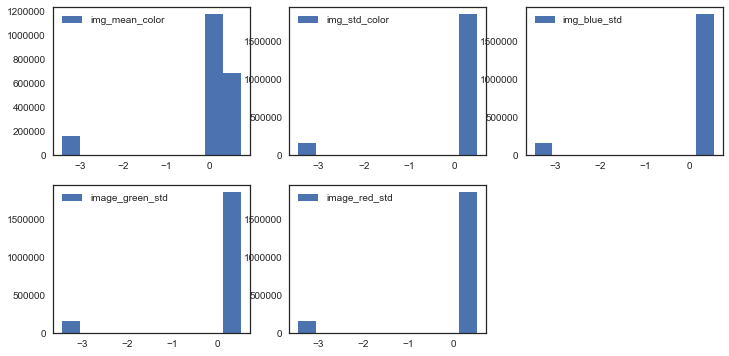

(2011862, 5)
Memory usage of dataframe is 92.10 MB
Memory usage after optimization is: 53.72 MB
Decreased by 41.7%
(2011862, 123)
917.1200141906738  MB


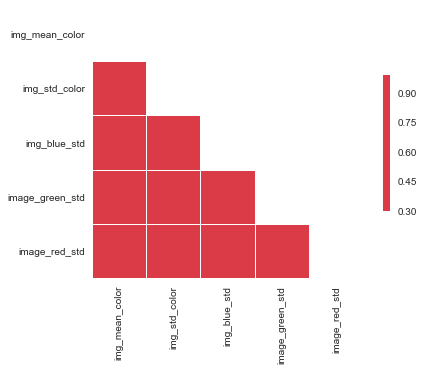

In [11]:
# image external
df = loadfeather('../features/external/image_external_train.feather', '../features/external/image_external_test.feather')
drops = ['img_blue_mean', 'img_green_mean', 'img_red_mean']
df.drop(drops, axis=1, inplace=True)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

population    1380
dtype: int64


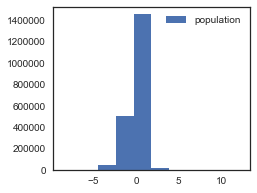

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 124)
924.7946586608887  MB


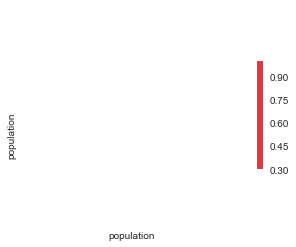

In [12]:
# city population
df = loadfeather('../features/external/city_population_train.feather', '../features/external/city_population_test.feather')
df['population'] = df['population'].fillna(df['population'].mean())
df['population'] = np.log(df['population'])
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

latitude                         1822
longitude                        1822
lat_lon_hdbscan_cluster_05_03      67
lat_lon_hdbscan_cluster_10_03      46
lat_lon_hdbscan_cluster_20_03      23
dtype: int64
lat_lon_hdbscan_cluster_05_03
lat_lon_hdbscan_cluster_10_03
lat_lon_hdbscan_cluster_20_03


C:\Users\ahega\Anaconda3\envs\Avito18_Kaggle\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


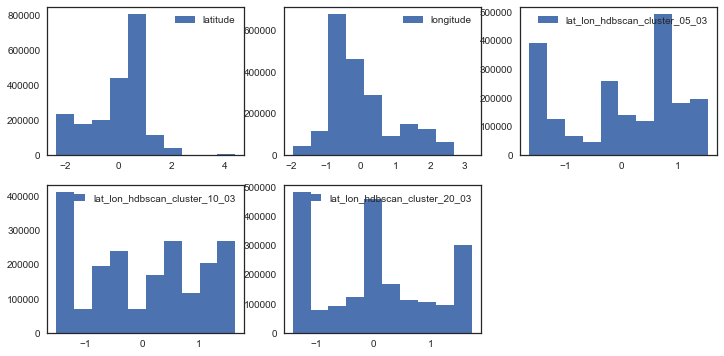

(2011862, 5)
Memory usage of dataframe is 92.10 MB
Memory usage after optimization is: 53.72 MB
Decreased by 41.7%
(2011862, 129)
963.1678810119629  MB


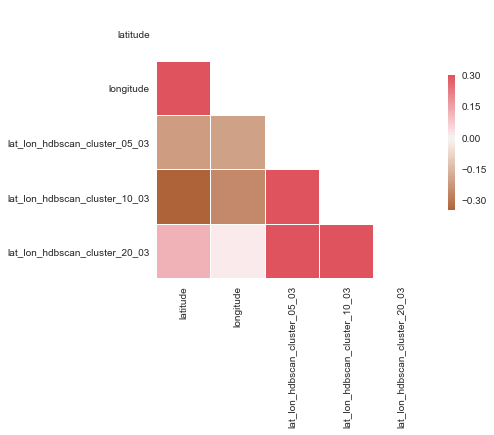

In [13]:
# City Region Features
df = loadfeather('../features/external/city_region_features_train.feather', '../features/external/city_region_features_test.feather')
df = scale_minmax(df)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

In [14]:
# Currency
# City Region Features
'''
df = loadfeather('../features/external/currency_features_train.feather', '../features/external/currency_features_test.feather')
drops = [col for col in df.columns if col.count('next') > 0]
df.drop(drops, axis=1, inplace=True)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/external/currency_features_train.feather', '../features/external/currency_features_test.feather')\ndrops = [col for col in df.columns if col.count('next') > 0]\ndf.drop(drops, axis=1, inplace=True)\ndf = scale_standard(df)\nplothist(df)\nplotcorr(df)\ndfmaster = concat2master(df, dfmaster)\n"

In [15]:
# Create fulldata

train = dfmaster[:lentrain]
test = dfmaster[lentrain: lentrain+lentest]

print(train.shape)
print(test.shape)

train.to_feather('../features/featured/train_full_7.feather')
test.to_feather('../features/featured/test_full_7.feather')

del train, test; gc.collect()
categorical


(1503424, 129)
(508438, 129)


['user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'user_type',
 'image_top_1',
 'param_1',
 'param_2',
 'param_3']

In [16]:
dfmaster.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,...,img_std_color,img_blue_std,image_green_std,image_red_std,population,latitude,longitude,lat_lon_hdbscan_cluster_05_03,lat_lon_hdbscan_cluster_10_03,lat_lon_hdbscan_cluster_20_03
0,884270,19,462,4,42,249,112,1217,-0.677024,-1.297002,...,0.335662,0.322732,0.338813,0.283195,0.875202,0.841237,0.267387,1.530656,1.215379,1.707508
1,227908,17,1314,2,22,122,112,1217,0.053957,-0.300643,...,0.291682,0.307905,0.291294,0.283222,0.708567,-0.004810,-0.300507,1.193258,1.076180,1.423260
2,576261,16,1290,0,2,84,112,1217,0.158324,-0.664681,...,0.412636,0.421438,0.420644,0.419150,0.679091,-1.417262,-0.875799,0.614861,1.354579,0.002020
3,755087,21,950,4,42,38,112,1217,-0.058564,1.098347,...,0.321899,0.326001,0.331929,0.330528,0.105544,0.577735,-0.182883,1.048659,0.867380,1.281136
4,944363,4,318,6,0,278,124,46,0.993673,-1.145913,...,0.292497,0.307537,0.300595,0.287914,0.600987,-1.070996,-0.612657,-0.108135,-0.246220,-1.419219


In [17]:
dfmaster.columns[20:50]

Index(['avg_days_up_user', 'avg_times_up_user', 'avg_headdays_up_user',
       'n_user_items', 'avg_price_up_user', 'var_price_up_user',
       'title_titleword_count', 'title_upper_case_word_count',
       'title_num_stopwords', 'title_num_punctuations', 'title_num_chars',
       'title_chars_by_words', 'title_words_by_uniquewords',
       'title_punctuations_by_chars', 'title_punctuations_by_words',
       'title_stopwords_by_words', 'title_mean', 'description_titleword_count',
       'description_upper_case_word_count', 'description_num_stopwords',
       'description_num_punctuations', 'description_num_chars',
       'description_chars_by_words', 'description_words_by_uniquewords',
       'description_punctuations_by_chars',
       'description_punctuations_by_words', 'description_stopwords_by_words',
       'description_mean', 'title_description_len_ratio',
       'parent_category_name-category_name-user_type_numunique'],
      dtype='object')